In [7]:
import numpy as np
from scipy.special import expit  # 로지스틱 함수 (inverse logit)
from scipy.stats import bernoulli
import cmdstanpy
import os

In [8]:
# 저장 경로 설정 (현재 작업 디렉토리)
stan_file_path = "rasch_model.stan"

# Stan 모델 코드 정의
stan_code = """
data {
  int<lower=0> I; // people
  int<lower=1> J;             // difficulty
  array[I, J] int<lower=0, upper=1> y;  // 응답 행렬 (0:오답, 1:정답)
}

parameters {
  vector[I] theta;          // 학생 능력 (Estimated)
  vector[J] beta; // difficulty
}

model {

// prior
theta ~ normal(0, 1); // identifiability가 필요함. 왜? 능력 - 난도 0이면 1이던, 100이던 다 0이 되어서 '알 수 없음'이 되어버림
beta ~ normal(0, 1); // theta 혹은 beta 둘 중 하나는 꼭 필요함

for (i in 1:I) {
  for (j in 1:J) {
        y[i,j] ~ bernoulli_logit(theta[i] - beta[j]);
    }
  }
}

"""

# 파일로 저장
with open(stan_file_path, "w") as f:
    f.write(stan_code)

print(f"Stan 모델 파일 생성 완료: {stan_file_path}")

Stan 모델 파일 생성 완료: rasch_model.stan


In [23]:
# 재현성을 위한 시드 설정
np.random.seed(42)

# 1. 기본 설정
N = 300   # 학생 수
J = 10   # 문항 수

# 2. 파라미터 생성 (Uniform -2 ~ 2)
theta_true = np.random.normal(0, 1, N)
beta_true = np.random.uniform(-3, 3, J)

y = np.zeros((N, J), dtype=int)

for n in range(N):
    for j in range(J):
        difference = theta_true[n] - beta_true[j]
        p = expit(difference)
        y[n, j] = bernoulli.rvs(p)

data = {
    'I':N, 
    'J':J, 
    'y':y}


In [24]:
# 1. 모델 컴파일
model = cmdstanpy.CmdStanModel(stan_file=stan_file_path)
print("모델 컴파일 완료")

모델 컴파일 완료


In [25]:
opt = model.optimize(data=data)
estimated_theta = opt.stan_variable('theta')
print(estimated_theta)

16:12:18 - cmdstanpy - INFO - Chain [1] start processing
16:12:18 - cmdstanpy - INFO - Chain [1] done processing


[ 1.0528299  -0.1084302  -0.10839442  0.6658495  -0.10840467  0.27941496
  0.6658038   1.0528355   0.27937013  1.0528567   0.27933967 -0.50036329
  0.27939997 -0.10839584 -0.90153442 -0.50036245 -0.90154689  0.27943188
 -0.90149877 -0.90158014  0.27938475 -0.50036751  0.27941914 -1.3199836
 -0.10841375  0.27938124 -0.10845081  0.27942261 -0.10840133  0.2794038
  0.27934923  1.8429572  -0.50036669 -0.50036126  0.66585542 -0.1084407
  0.66581071 -0.10838534 -1.7671933   0.66583108  0.66587533 -0.50035967
  0.27937913  0.27938826 -0.50036489 -0.1084504   0.27940412  1.0528339
 -0.10845141 -0.10840316  0.27937923 -0.50036753 -0.90153624 -0.50035711
  0.66581377  1.0529064  -0.10844851 -0.50036734 -0.10840432  0.66581969
 -0.90150883 -0.90157498  0.27939866 -1.7675173  -0.10842488  0.66580093
 -0.50036752 -0.10838756  0.66579069  0.27941316 -0.10839946  1.0528717
 -0.90155258  0.66586256 -1.3199611   0.66580487  0.66588228 -0.90154227
  1.4434077  -1.3198157  -0.5003675   1.0528566   1.4434

In [26]:
# 3. 모델 적합 (추천: MCMC Sampling)
# optimize 대신 sample을 사용하는 것이 베이지안 분석에 더 적합합니다.
fit = model.sample(data=data, 
                   chains=4,           # 체인 수 (보통 4)
                   iter_warmup=1000,   # 워밍업 반복 수
                   iter_sampling=1000, # 실제 샘플링 수
                   show_progress=True)

print("모델 적합(Sampling) 완료")

# 4. 결과 확인
print(fit.summary().head()) # 결과 요약표 출력 (상위 5개)

# (참고) 만약 optimize를 꼭 써야 한다면 아래와 같이 결과를 꺼냅니다.


16:12:18 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status






chain 1 |▉         | 00:02 Iteration:    1 / 2000 [  0%]  (Warmup)


chain 1 |█▎        | 00:04 Iteration:  100 / 2000 [  5%]  (Warmup)


chain 1 |█▊        | 00:06 Iteration:  200 / 2000 [ 10%]  (Warmup)


chain 1 |██▎       | 00:07 Iteration:  300 / 2000 [ 15%]  (Warmup)


chain 1 |██▋       | 00:09 Iteration:  400 / 2000 [ 20%]  (Warmup)


chain 1 |███▏      | 00:10 Iteration:  500 / 2000 [ 25%]  (Warmup)


chain 1 |███▋      | 00:11 Iteration:  600 / 2000 [ 30%]  (Warmup)


chain 1 |████      | 00:13 Iteration:  700 / 2000 [ 35%]  (Warmup)


chain 1 |████▌     | 00:14 Iteration:  800 / 2000 [ 40%]  (Warmup)


chain 1 |█████     | 00:16 Iteration:  900 / 2000 [ 45%]  (Warmup)


chain 1 |█████▉    | 00:18 Iteration: 1001 / 2000 [ 50%]  (Sampling)


chain 1 |██████▎   | 00:19 Iteration: 1100 / 2000 [ 55%]  (Sampling)


chain 1 |██████▊   | 00:21 Iteration: 1200 / 2000 [ 60%]  (Sampling)


chain 1 |███████▎  | 00:23 Iteration: 1300 / 2000 [ 65%]  (Sampling)


chain 1 |███████▋  | 


16:12:51 - cmdstanpy - INFO - CmdStan done processing.



모델 적합(Sampling) 완료
                 Mean      MCSE     StdDev        MAD           5%  \
lp__     -1479.610000  0.343551  12.641600  13.036400 -1500.230000   
theta[1]     1.083720  0.007566   0.627237   0.628734     0.065187   
theta[2]    -0.109226  0.006174   0.643902   0.628827    -1.169580   
theta[3]    -0.112871  0.006851   0.647278   0.665361    -1.169910   
theta[4]     0.692237  0.007016   0.621467   0.626192    -0.351575   

                  50%          95%  ESS_bulk  ESS_tail  ESS_bulk/s    R_hat  
lp__     -1479.400000 -1459.420000   1347.44   1788.50     21.5597  1.00083  
theta[1]     1.072530     2.111250   7085.73   2566.88    113.3750  1.00148  
theta[2]    -0.107783     0.936064  11043.00   2703.67    176.6940  1.00111  
theta[3]    -0.111994     0.956597   9522.66   2451.30    152.3670  1.00067  
theta[4]     0.697222     1.689050   8232.76   2882.14    131.7280  1.00069  


In [27]:
# 전체 요약표 가져오기
summary_df = fit.summary()

# 'theta'로 시작하는 파라미터만 필터링 (학생별 능력치)
theta_summary = summary_df[summary_df.index.str.startswith('theta')]

# 결과 출력 (Mean: 추정된 능력 평균, 5%~95%: 신뢰구간)
print(theta_summary[['Mean', 'StdDev', '5%', '95%']])

                Mean    StdDev        5%       95%
theta[1]    1.083720  0.627237  0.065187  2.111250
theta[2]   -0.109226  0.643902 -1.169580  0.936064
theta[3]   -0.112871  0.647278 -1.169910  0.956597
theta[4]    0.692237  0.621467 -0.351575  1.689050
theta[5]   -0.112207  0.647927 -1.168210  0.929323
...              ...       ...       ...       ...
theta[296] -0.523338  0.625494 -1.535490  0.484590
theta[297]  0.293063  0.632786 -0.744462  1.325910
theta[298] -0.103108  0.640576 -1.161460  0.946680
theta[299]  0.688424  0.644301 -0.353197  1.755050
theta[300] -0.527076  0.642303 -1.594930  0.516855

[300 rows x 4 columns]


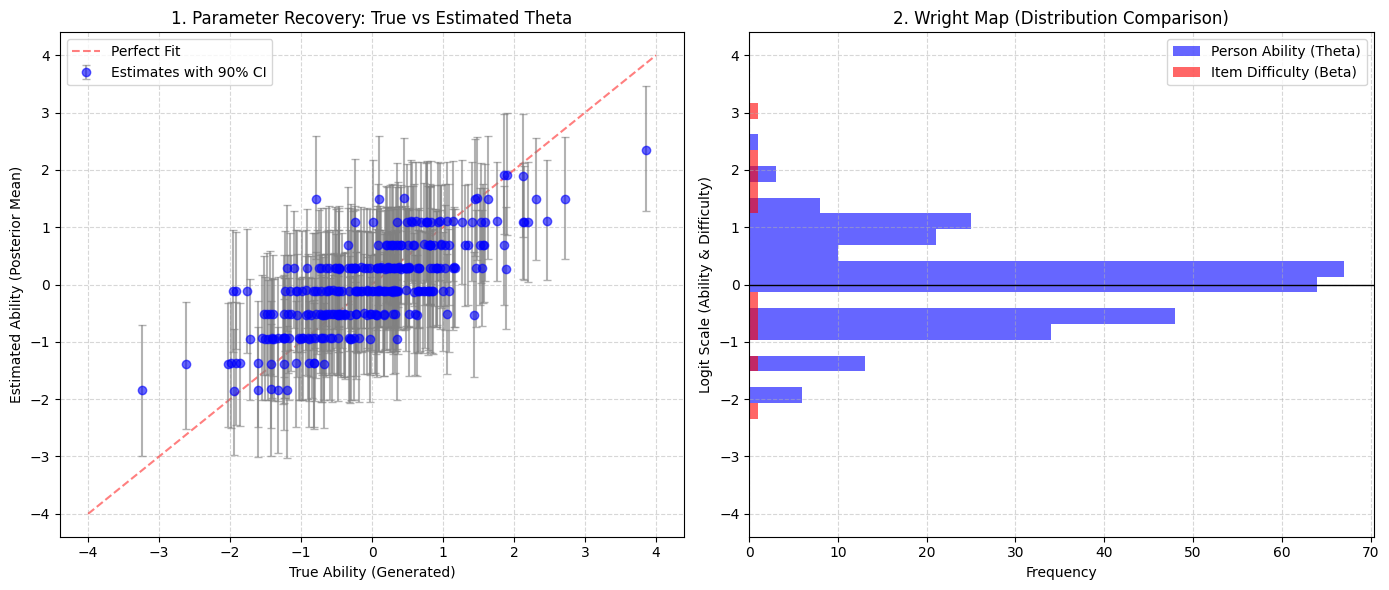

In [28]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. 데이터 추출 및 정리
summary = fit.summary()

# Theta (학생 능력) 통계
theta_df = summary[summary.index.str.startswith('theta')]
theta_est = theta_df['Mean'].values
theta_lower = theta_df['5%'].values
theta_upper = theta_df['95%'].values
theta_err = [theta_est - theta_lower, theta_upper - theta_est] # 에러바용

# Beta (문항 난이도) 통계 - Wright Map용
beta_df = summary[summary.index.str.startswith('beta')]
beta_est = beta_df['Mean'].values

# -------------------------------------------------------
# 시각화 1: Parameter Recovery (참값 vs 추정값)
# -------------------------------------------------------
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
# y=x 기준선 (Perfect Recovery)
plt.plot([-4, 4], [-4, 4], 'r--', alpha=0.5, label='Perfect Fit')

# 산점도 및 에러바 (신뢰구간 90%)
plt.errorbar(theta_true, theta_est, yerr=theta_err, fmt='o', 
             ecolor='gray', color='blue', alpha=0.6, capsize=3, label='Estimates with 90% CI')

plt.title('1. Parameter Recovery: True vs Estimated Theta')
plt.xlabel('True Ability (Generated)')
plt.ylabel('Estimated Ability (Posterior Mean)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

# -------------------------------------------------------
# 시각화 2: Wright Map (Person-Item Map)
# -------------------------------------------------------
# 학생 능력 분포와 문항 난이도 분포를 같은 축(y축)에 그립니다.
plt.subplot(1, 2, 2)

# 공통 bins 설정
bins = np.linspace(-4, 4, 30)

# 학생 능력 히스토그램 (왼쪽)
plt.hist(theta_est, bins=bins, orientation='horizontal', alpha=0.6, 
         color='blue', label='Person Ability (Theta)')

# 문항 난이도 히스토그램 (오른쪽 - 겹쳐서 비교)
# 문항 난이도를 더 잘 보이게 하기 위해 투명도 조절 또는 별도 표시
plt.hist(beta_est, bins=bins, orientation='horizontal', alpha=0.6, 
         color='red', label='Item Difficulty (Beta)')

# 중심선 (0 logit)
plt.axhline(0, color='black', linestyle='-', linewidth=1)

plt.title('2. Wright Map (Distribution Comparison)')
plt.xlabel('Frequency')
plt.ylabel('Logit Scale (Ability & Difficulty)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

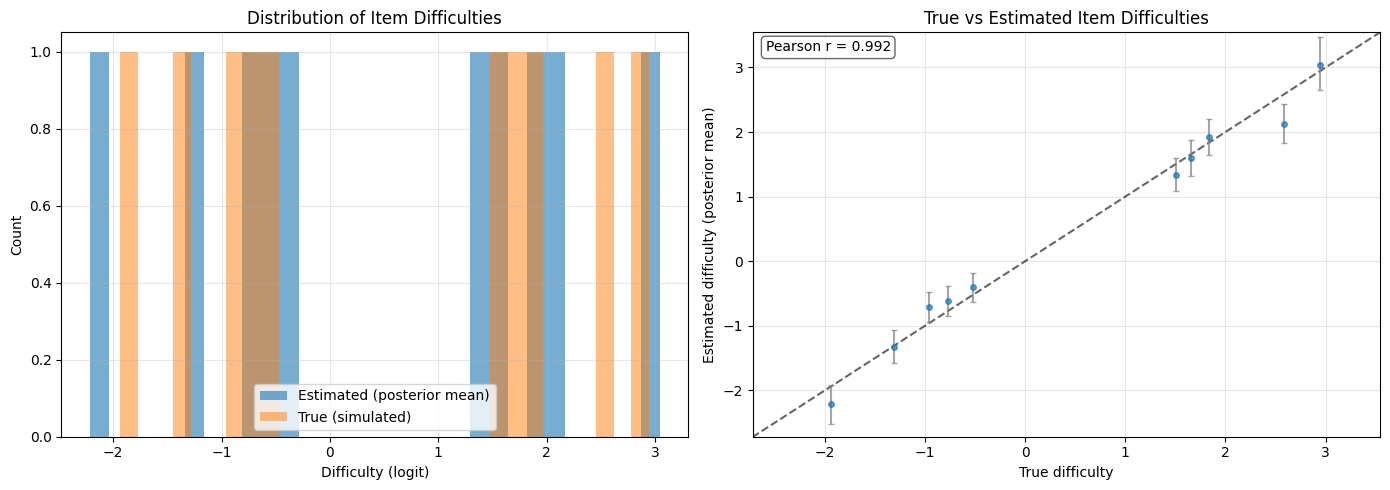

In [29]:
# Plot item difficulties: distribution and true vs estimated (with 90% CI)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1) Histogram: estimated vs true difficulties
axes[0].hist(beta_est, bins=30, alpha=0.6, color='C0', label='Estimated (posterior mean)')
axes[0].hist(beta_true, bins=30, alpha=0.5, color='C1', label='True (simulated)')
axes[0].set_title('Distribution of Item Difficulties')
axes[0].set_xlabel('Difficulty (logit)')
axes[0].set_ylabel('Count')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 2) True vs Estimated scatter with 90% credible intervals (from beta_df 5%/95%)
lower = beta_df['5%'].values
upper = beta_df['95%'].values
yerr = np.vstack([beta_est - lower, upper - beta_est])

axes[1].plot([-4, 4], [-4, 4], 'k--', alpha=0.6, label='y = x')
axes[1].errorbar(beta_true, beta_est, yerr=yerr, fmt='o', ms=4, alpha=0.7,
                 ecolor='gray', color='C0', capsize=2, label='Estimates ± 90% CI')
axes[1].set_xlim(min(beta_true.min(), beta_est.min()) - 0.5, max(beta_true.max(), beta_est.max()) + 0.5)
axes[1].set_ylim(axes[1].get_xlim())
axes[1].set_title('True vs Estimated Item Difficulties')
axes[1].set_xlabel('True difficulty')
axes[1].set_ylabel('Estimated difficulty (posterior mean)')
axes[1].grid(alpha=0.3)

# Correlation annotation
corr = np.corrcoef(beta_true, beta_est)[0, 1]
axes[1].text(0.02, 0.98, f'Pearson r = {corr:.3f}', transform=axes[1].transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()